Required packages...

In [ ]:
!pip install investpy # https://investpy.readthedocs.io/
!pip install hurst # https://pypi.org/project/hurst/

Import libraries...

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
import investpy
from hurst import compute_Hc
import datetime

#ONLY run the following if saving to / loading from static copy...

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
curr_dir = '/content/gdrive/My Drive/Datasets'
os.chdir(curr_dir)
!ls

data_combined_daily_OHLC_logret_transposed.csv	data_combined_daily_static.csv
data_combined_daily_OHLC_log_transposed.csv	temp.csv
data_combined_daily_OHLC_pct_transposed.csv	winequality-red.csv
data_combined_daily_OHLC_transposed.csv


Saving...

In [ ]:
t0 = datetime.datetime.now()

# stacked raw
filename = 'data_combined_daily_static.csv'
path = curr_dir + '/' + filename
path
data_combined_daily.to_csv(path)

# OHLC transposed with hurst and trend
filename = 'data_combined_daily_OHLC_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_transposed.to_csv(path)

# percent change transposed
filename = 'data_combined_daily_OHLC_pct_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_pct_transposed.to_csv(path)

# log prices tranposed with hurst and trend
filename = 'data_combined_daily_OHLC_log_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_log_transposed.to_csv(path)

# log prices tranposed with hurst and trend
filename = 'data_combined_daily_OHLC_logret_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_logret_transposed.to_csv(path)

t0 = datetime.datetime.now() - t0
print('file save exec time: ', t0,'s')

Loading...

In [8]:
# log prices
filename = 'temp.csv'
path = curr_dir + '/' + filename
path

data_combined_daily_OHLC_refactored_log = pd.read_csv(path, index_col = 0)
print(data_combined_daily_OHLC_refactored_log.shape)
print(data_combined_daily_OHLC_refactored_log.nunique())

(731, 11959)
.LMEX       492
00636K      450
00657K      442
00668K      274
0JSJ        113
           ... 
ZVO         456
ZYD         707
Zinc        502
invus30     491
invus500    503
Length: 11959, dtype: int64


In [5]:
# log prices tranposed with hurst and trend
filename = 'data_combined_daily_OHLC_log_transposed.csv'
path = curr_dir + '/' + filename
path

data_combined_daily_OHLC_log_transposed = pd.read_csv(path, index_col = 0)
print(data_combined_daily_OHLC_log_transposed.shape)
print(data_combined_daily_OHLC_log_transposed.nunique())

(11959, 731)
2019-05-31    11035
2019-06-01    11050
2019-06-02    11050
2019-06-03    11015
2019-06-04    11058
              ...  
2021-05-26    11211
2021-05-27    11183
2021-05-28    11221
2021-05-29    11116
2021-05-30    11133
Length: 731, dtype: int64


In [ ]:
data_combined_daily_OHLC_log_transposed

#API calls to fetch from investing.com

https://investpy.readthedocs.io/api.html

In [ ]:
# global indices
indices_universe = investpy.indices.get_indices(country=None)
indices_universe['mask'] = [ len(thisSymbol) for thisSymbol in indices_universe.symbol ]
indices_major_usd = indices_universe.loc[(indices_universe['class'] == 'major_indices') & (indices_universe['currency'] == 'USD') & (indices_universe['mask'] <= 4)]
indices_usd = indices_universe.loc[(indices_universe['currency'] == 'USD')]

# global equites
equities_universe = investpy.stocks.get_stocks(country=None)
equities_usd = equities_universe[equities_universe['currency'] == 'USD']

# exchanged-traded funds
etf_universe = investpy.etfs.get_etfs(country=None)
etf_usd = etf_universe[etf_universe['currency'] == 'USD']

# currency cross pairs
currency_universe = investpy.currency_crosses.get_currency_crosses(base=None, second=None)
currency_usd = currency_universe[currency_universe['second'] == 'USD']

# bond yields
bonds_universe = investpy.bonds.get_bonds(country=None)

# commodities
commodities_universe = investpy.commodities.get_commodities(group=None)
commodities_borderless = commodities_universe[commodities_universe['country'].isnull()]
frames = [commodities_borderless, commodities_universe[commodities_universe['country'] == 'united states']]
commodities_borderless = pd.concat(frames)

# cryptocurrencies
crypto_universe = investpy.crypto.get_cryptos()

# import from investing.com - daily interval - all at once!

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

t1 = datetime.datetime.now()

data_combined_daily = pd.DataFrame()

now = datetime.datetime.now()
end = str(now.day)+"/"+str(now.month)+"/"+str(now.year)
look_back_period = 365*2
min_threshold_LBP = int(0.10 * look_back_period)
start = now - datetime.timedelta(days=look_back_period)
start = str(start.day)+"/"+str(start.month)+"/"+str(start.year)

# INDICES

t0 = datetime.datetime.now()

symbols = indices_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.get_index_historical_data(index=row['name'], country=row['country'], from_date=start, to_date=end)
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'INDEX'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('indices exec time: ', t0,'s')

# EQUITIES

t0 = datetime.datetime.now()

symbols = equities_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.stocks.get_stock_historical_data(stock=row['symbol'], country=row['country'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'EQUITY'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('EQUITIES exec time: ', t0,'s')

# ETF

t0 = datetime.datetime.now()

symbols = etf_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.etfs.get_etf_historical_data(etf=row['name'], country=row['country'], from_date=start, to_date=end, stock_exchange=None, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'ETF'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('ETF exec time: ', t0,'s')

# currencies

t0 = datetime.datetime.now()

symbols = currency_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.currency_crosses.get_currency_cross_historical_data(currency_cross=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['full_name']
    temp_df['symbol'] = row['name']
    temp_df['symbol_cat'] = 'CURRENCY'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)
  
t0 = datetime.datetime.now() - t0
print('currencies exec time: ', t0,'s')

# bonds

t0 = datetime.datetime.now()

symbols = bonds_universe

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.bonds.get_bond_historical_data(bond=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['full_name']
    temp_df['symbol'] = row['name']
    temp_df['symbol_cat'] = 'BOND_YLD'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('bonds exec time: ', t0,'s')

# commodities

t0 = datetime.datetime.now()

symbols = commodities_universe

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.commodities.get_commodity_historical_data(commodity=row['name'], from_date=start, to_date=end, country=None, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['full_name']
    temp_df['symbol'] = row['name']
    temp_df['symbol_cat'] = 'COMMODITY'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('commodities exec time: ', t0,'s')

# crypto

t0 = datetime.datetime.now()

symbols = crypto_universe

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.crypto.get_crypto_historical_data(crypto=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'CRYPTO'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('crypto exec time: ', t0,'s')

data_combined_daily['OHLC'] = 0.25*(data_combined_daily['Open']+data_combined_daily['High']+data_combined_daily['Low']+data_combined_daily['Close'])

data_combined_daily.reset_index(inplace=True)
data_combined_daily['idx'] = data_combined_daily['Date']
data_combined_daily = data_combined_daily.set_index('idx')

t1 = datetime.datetime.now() - t1
print('TOTAL exec time: ', t1,'s')

Refactor from long to wide; then transpose.

Also note the [groupby + aggregate + unstack] method for long to wide refactoring.

https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns

In [ ]:
# https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns

t0 = datetime.datetime.now()

temp_df = data_combined_daily[['OHLC','symbol']]
data_combined_daily_OHLC_refactored = temp_df.pivot_table(values='OHLC', index=temp_df.index, columns='symbol', aggfunc='first')
data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.fillna(method='ffill')
data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.fillna(method='bfill')
data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.dropna()

for column in data_combined_daily_OHLC_refactored.loc[:, (data_combined_daily_OHLC_refactored == 0).all()].columns:
  data_combined_daily_OHLC_refactored['column'] = 1

t0 = datetime.datetime.now() - t0
print('Section exec time: ', t0,'s')

Calculate returns, log returns and log prices.

In [ ]:
t0 = datetime.datetime.now()

data_combined_daily_OHLC_refactored_subset = data_combined_daily_OHLC_refactored.loc[:, (data_combined_daily_OHLC_refactored > 0).all(axis=0)]

# daily percentage change
data_combined_daily_OHLC_refactored_pct = data_combined_daily_OHLC_refactored_subset.pct_change()
data_combined_daily_OHLC_refactored_pct = data_combined_daily_OHLC_refactored_subset.dropna()

# log prices
data_combined_daily_OHLC_refactored_log = np.log(data_combined_daily_OHLC_refactored_subset)

# log returns
data_combined_daily_OHLC_refactored_log_ret = np.log(data_combined_daily_OHLC_refactored_subset) - np.log(data_combined_daily_OHLC_refactored_subset.shift(1))
data_combined_daily_OHLC_refactored_log_ret = data_combined_daily_OHLC_refactored_log_ret.fillna(method='ffill')
data_combined_daily_OHLC_refactored_log_ret = data_combined_daily_OHLC_refactored_log_ret.fillna(method='bfill')

# transpose
data_combined_daily_OHLC_transposed = data_combined_daily_OHLC_refactored_subset.T # or data_combined_daily_OHLC_refactored.transpose()
data_combined_daily_OHLC_pct_transposed = data_combined_daily_OHLC_refactored_pct.T
data_combined_daily_OHLC_log_transposed = data_combined_daily_OHLC_refactored_log.T
data_combined_daily_OHLC_logret_transposed = data_combined_daily_OHLC_refactored_log_ret.T

t0 = datetime.datetime.now() - t0
print('Section exec time: ', t0,'s')

Calculate Hurst Exponent using vanilla Rescaled Range (R/S) method

In [9]:
hurst = []

for column in data_combined_daily_OHLC_refactored_log.columns:
  subset = data_combined_daily_OHLC_refactored_log[column]
  try:
    H, c, dataset = compute_Hc(subset, kind='price', simplified=True)
    hurst.append(H)
  except:
    hurst.append(None)

data_combined_daily_OHLC_log_transposed['hurst'] = [x for x in hurst]
data_combined_daily_OHLC_log_transposed = data_combined_daily_OHLC_log_transposed.dropna()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Looksy...

In [10]:
subset = data_combined_daily_OHLC_log_transposed['hurst']
print(subset.describe())
print('\nSkewness: ',skew(subset))
print('\nKurtosis: ',kurtosis(subset))

count    10138.000000
mean         0.591383
std          0.090289
min          0.017905
25%          0.550117
50%          0.592210
75%          0.629625
max          1.564705
Name: hurst, dtype: float64

Skewness:  0.4068765804428021

Kurtosis:  12.117919878267951


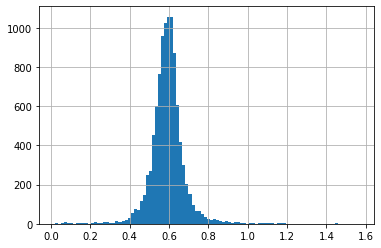

In [11]:
hist = data_combined_daily_OHLC_log_transposed['hurst'].hist(bins=100)

Assign trend labels...

In [12]:
epsilon = 0.05
print('Below Range: ',subset[(subset < 0)].count())
print('Anti-Persistent (Mean-Reverting): ',subset[(subset >= 0) & (subset < 0.5 - epsilon)].count())
print('Brownian Motion: ',subset[(subset >= 0.5 - epsilon) & (subset <= 0.5 + epsilon)].count())
print('Persistent (Trending): ',subset[(subset > 0.5 + epsilon) & (subset <= 1.0)].count())
print('Above Range: ',subset[(subset > 1.0)].count())

Below Range:  0
Anti-Persistent (Mean-Reverting):  376
Brownian Motion:  2153
Persistent (Trending):  7576
Above Range:  33


In [13]:
epsilon = 0.05
trend = []

for hurst_value in data_combined_daily_OHLC_log_transposed['hurst']:
  if (hurst_value < 0):
    trend.append('Below_Bound')
  elif (hurst_value >= 0) & (hurst_value < 0.5 - epsilon):
    trend.append('Mean_Revert')
  elif (hurst_value >= 0.5 - epsilon) & (hurst_value <= 0.5 + epsilon):
    trend.append('Brownian')
  elif (hurst_value > 0.5 + epsilon) & (hurst_value <= 1):
    trend.append('Trending')
  elif (hurst_value > 1):
    trend.append('Above_Bound')

data_combined_daily_OHLC_log_transposed['trend'] = [x for x in trend]

print('Below Range: ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Below_Bound'].shape[0])
print('Anti-Persistent (Mean-Reverting): ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Mean_Revert'].shape[0])
print('Brownian Motion: ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Brownian'].shape[0])
print('Persistent (Trending): ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Trending'].shape[0])
print('Above Range: ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Above_Bound'].shape[0])

Below Range:  0
Anti-Persistent (Mean-Reverting):  376
Brownian Motion:  2153
Persistent (Trending):  7576
Above Range:  33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# Machine Learnin' Time!

In [14]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics.cluster import silhouette_score

import plotly.graph_objects as go

Standardise...

In [15]:
# center and scale the data

data_features = data_combined_daily_OHLC_log_transposed.columns[0:-2]
data_scaled = StandardScaler().fit_transform(data_combined_daily_OHLC_log_transposed[data_features])
data_scaled = pd.DataFrame(data_scaled,columns=data_features)
print("Before scaling:\n", data_combined_daily_OHLC_log_transposed[data_features].describe())
print("\nAfter scaling:\n", np.round(data_scaled.describe(),2))

Before scaling:
          2019-05-31    2019-06-01  ...    2021-05-29    2021-05-30
count  10138.000000  10138.000000  ...  10138.000000  10138.000000
mean       4.319161      4.318734  ...      4.528643      4.528082
std        1.990490      1.991046  ...      2.056376      2.056879
min        0.009207      0.009207  ...      0.046406      0.046406
25%        2.952433      2.950016  ...      3.108558      3.107385
50%        3.842003      3.842003  ...      4.084042      4.084042
75%        5.710389      5.710389  ...      5.940715      5.940715
max       12.604177     12.604177  ...     13.110772     13.110772

[8 rows x 731 columns]

After scaling:
        2019-05-31  2019-06-01  2019-06-02  ...  2021-05-28  2021-05-29  2021-05-30
count    10138.00    10138.00    10138.00  ...    10138.00    10138.00    10138.00
mean         0.00       -0.00        0.00  ...        0.00        0.00       -0.00
std          1.00        1.00        1.00  ...        1.00        1.00        1.00
min    

Get silhouette scores...

###Logistic Regression...

###KMeans++

Get silhouette scores...

In [ ]:
t1 = datetime.datetime.now()

N = 16
k_range = range(2,N+1)
sil_scores = []

for k in k_range:
    print('clusters: ', k)
    km_ss = KMeans(n_clusters=k, init='k-means++', n_init=100, max_iter=1000, tol=1e-5, random_state=1984, algorithm='auto')
    km_ss.fit(data_scaled)
    sil_scores.append(silhouette_score(data_scaled, km_ss.labels_))

t1 = datetime.datetime.now() - t1
print('section exec time: ', t1,'s')

fig = go.Figure(data=go.Scatter(x=list(range(2,N+1,1)), y=sil_scores))

fig.update_layout(title='silhouette scores for N = ' + str(N),
                   xaxis_title='clusters',
                   yaxis_title='silhouette score')

fig.show()

clusters:  2
clusters:  3
clusters:  4
clusters:  5
clusters:  6
clusters:  7
clusters:  8
clusters:  9
clusters:  10
clusters:  11
clusters:  12
clusters:  13
clusters:  14
clusters:  15
clusters:  16
section exec time:  0:25:57.851457 s


Run the running cluster size...

In [16]:
km_ss = KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=1000, tol=1e-5, random_state=1984, algorithm='auto')
km_ss.fit(data_scaled)

data_combined_daily_OHLC_log_transposed['cluster'] = [x for x in km_ss.labels_]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data = data_combined_daily_OHLC_log_transposed.iloc[:, [0] + [-4,-1]]
data.columns = ['x', 'y','cluster']

import plotly.express as px

fig = px.scatter(data, x='x', y='y', color="cluster")

fig.show()

In [17]:
data = data_combined_daily_OHLC_log_transposed.drop(['hurst','trend'],axis=1)
data[data.columns]

,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,...,2021-04-22,2021-04-23,2021-04-24,2021-04-25,2021-04-26,2021-04-27,2021-04-28,2021-04-29,2021-04-30,2021-05-01,2021-05-02,2021-05-03,2021-05-04,2021-05-05,2021-05-06,2021-05-07,2021-05-08,2021-05-09,2021-05-10,2021-05-11,2021-05-12,2021-05-13,2021-05-14,2021-05-15,2021-05-16,2021-05-17,2021-05-18,2021-05-19,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29,2021-05-30,cluster
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.LMEX,7.924109,7.924109,7.924109,7.920882,7.925700,7.916844,7.919683,7.914216,7.914216,7.914216,7.924217,7.927505,7.926278,7.925013,7.917208,7.917208,7.917208,7.918556,7.934836,7.931213,7.937482,7.932470,7.932470,7.932470,7.937696,7.951313,7.945485,7.942185,7.943996,7.943996,7.943996,7.935587,7.923384,7.928730,7.929523,7.927360,7.927360,7.927360,7.927469,7.922841,...,8.294525,8.306003,8.306003,8.306003,8.324603,8.331707,8.338688,8.339716,8.337612,8.337612,8.337612,8.337612,8.350548,8.351634,8.365812,8.389337,8.389337,8.389337,8.384416,8.389860,8.382312,8.369250,8.366231,8.366231,8.366231,8.381282,8.384895,8.349768,8.352436,8.338760,8.338760,8.338760,8.342887,8.340719,8.346690,8.372976,8.377839,8.377839,8.377839,0
00636K,3.029288,3.029288,3.029288,3.027231,3.024563,3.026504,3.018594,3.018594,3.018594,3.018594,3.025776,3.039749,3.047376,3.043331,3.048206,3.048206,3.048206,3.044880,3.045712,3.066424,3.078694,3.089223,3.089223,3.089223,3.085573,3.078003,3.073619,3.079729,3.082025,3.082025,3.082025,3.111736,3.112404,3.108279,3.106043,3.104475,3.104475,3.104475,3.095464,3.086715,...,3.300179,3.302665,3.302665,3.302665,3.310908,3.293612,3.291569,3.299534,3.299534,3.299534,3.299534,3.298057,3.291661,3.295096,3.296392,3.293612,3.293612,3.293612,3.278370,3.278370,3.288682,3.281287,3.290080,3.290080,3.290080,3.311364,3.323866,3.320349,3.319626,3.319083,3.319083,3.319083,3.310361,3.333008,3.361590,3.363149,3.364706,3.364706,3.364706,1
00657K,3.244738,3.244738,3.244738,3.227439,3.225752,3.244544,3.246394,3.246394,3.246394,3.246394,3.261456,3.264327,3.265378,3.257519,3.260881,3.260881,3.260881,3.262893,3.258097,3.270329,3.274500,3.272417,3.272417,3.272417,3.269189,3.266332,3.261169,3.268808,3.268808,3.268808,3.268808,3.288495,3.293241,3.288588,3.291847,3.291383,3.291383,3.291383,3.285974,3.286348,...,3.579622,3.574590,3.574590,3.574590,3.581712,3.576550,3.575011,3.572346,3.572346,3.572346,3.572346,3.570940,3.572065,3.565581,3.582407,3.582963,3.582963,3.582963,3.590922,3.556633,3.536311,3.522825,3.534124,3.534124,3.534124,3.526361,3.553203,3.532299,3.538928,3.547316,3.547316,3.547316,3.548755,3.553060,3.556205,3.549474,3.572907,3.572907,3.572907,1
00668K,2.181547,2.181547,2.181547,2.162173,2.162173,2.191654,2.195000,2.195000,2.195000,2.195000,2.215937,2.221375,2.218116,2.218116,2.223542,2.223542,2.223542,2.223542,2.221375,2.231089,2.241773,2.248129,2.248129,2.248129,2.250239,2.249184,2.234306,2.237513,2.236445,2.236445,2.236445,2.247072,2.247072,2.244956,2.252344,2.253132,2.253132,2.253132,2.247072,2.243896,...,2.509599,2.503074,2.503074,2.503074,2.509599,2.505526,2.505526,2.504709,2.504709,2.504709,2.504709,2.505526,2.507972,2.507972,2.513656,2.524127,2.524127,2.524127,2.533697,2.525729,2.509599,2.497329,2.509599,2.509599,2.509599,2.517696,2.519308,2.505526,2.503074,2.512035,2.512035,2.512035,2.506750,2.521721,2.520113,2.512846,2.529721,2.529721,2.529721,2
0JSJ,3.296207,3.296207,3.296207,3.296207,3.296207,3.296207,3.296207,3.296207,3.296207,3.296207,3.296207,3.296207,3.285787,3.269569,3.26

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

data = data_combined_daily_OHLC_log_transposed.drop(['hurst','trend'],axis=1)

N = len(data.cluster.unique())
clusters = list(range(1,N+1))
#clusters = np.array(clusters)
row_space = [(x + 1) // 2 for x in clusters]
col_space = [2 if x==0 else x for x in [y % 2 for y in clusters]]

fig = go.Figure()
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{}, {}]],
           subplot_titles=(clusters),
           horizontal_spacing = 0.05,
           vertical_spacing  = 0.05,
    print_grid=True)

j = 0
for cluster in clusters:
  this_slice = data[data.cluster == cluster]
  this_slice = this_slice.drop(['cluster'],axis=1)
  k = 0
  for ticker in this_slice.index:
    fig.add_trace(go.Scatter(x=list(this_slice.columns), y=this_slice.loc[[this_slice.index[k]]].values.tolist()[0], mode='lines'), row=int(row_space[j]), col=int(col_space[j]))
    k += 1
  j += 1

fig.update_layout(height=1600, width=1600, title_text="Cluster Grid")
fig.update_layout(showlegend=False)
fig.show()

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [42]:
data = data_combined_daily_OHLC_log_transposed.drop(['hurst','trend'],axis=1)

N = len(data.cluster.unique())
clusters = list(range(1,N+1))
#clusters = np.array(clusters)
row_space = [(x + 1) // 2 for x in clusters]
col_space = [2 if x==0 else x for x in [y % 2 for y in clusters]]


In [44]:
row_space

[1, 1, 2, 2]

In [ ]:
this_slice = data[data.cluster == 3]
this_slice = this_slice.drop(['cluster'],axis=1)
this_slice.loc[['ZM']].values.tolist()[0]

In [28]:
this_slice = data[data.cluster == 3]
this_slice = this_slice.drop(['cluster'],axis=1)

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(this_slice.columns), y=this_slice.loc[['ZM']].values.tolist()[0],
                            mode='lines',
                            name='lines'))

fig.show()

In [36]:
this_slice = data[data.cluster == 3]
this_slice = this_slice.drop(['cluster'],axis=1)

import plotly.graph_objects as go

fig = go.Figure()

for ticker in this_slice.index:
  fig.add_trace(go.Scatter(x=list(this_slice.columns), y=this_slice.loc[[ticker]].values.tolist()[0],
                            mode='lines',
                            name='lines'))
  
fig.show()

In [ ]:
len(data.cluster.unique())

16

In [33]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

data = data_combined_daily_OHLC_log_transposed.drop(['hurst','trend'],axis=1)

N = len(data.cluster.unique())
clusters = list(range(1,N+1))
#clusters = np.array(clusters)
row_space = [(x + 3) // 4 for x in clusters]
col_space = [4 if x==0 else x for x in [y % 4 for y in clusters]]

fig = go.Figure()

fig = make_subplots(
    rows=4, cols=4,
    specs=[[{}, {}, {}, {}],
           [{}, {}, {}, {}],
           [{}, {}, {}, {}],
           [{}, {}, {}, {}]],
           subplot_titles=(clusters),
           horizontal_spacing = 0.05,
           vertical_spacing  = 0.05,
    print_grid=True)


this_slice = data[data.cluster == 2]
this_slice = this_slice.drop(['cluster'],axis=1)

for ticker in this_slice.index:
  fig.add_trace(go.Scatter(x=list(this_slice.columns), y=this_slice.loc[[ticker]].values.tolist()[0], mode='lines'), row=1, col=1)

this_slice = data[data.cluster == 3]
this_slice = this_slice.drop(['cluster'],axis=1)

for ticker in this_slice.index:
  fig.add_trace(go.Scatter(x=list(this_slice.columns), y=this_slice.loc[[ticker]].values.tolist()[0], mode='lines'), row=1, col=2)



fig.update_layout(height=1600, width=1600, title_text="Cluster Grid")
fig.update_layout(showlegend=False)
fig.show()

This is the format of your plot grid:
[ (1,1) x,y     ]  [ (1,2) x2,y2   ]  [ (1,3) x3,y3   ]  [ (1,4) x4,y4   ]
[ (2,1) x5,y5   ]  [ (2,2) x6,y6   ]  [ (2,3) x7,y7   ]  [ (2,4) x8,y8   ]
[ (3,1) x9,y9   ]  [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



In [ ]:
list(this_slice.columns)

###DBScan...